In [ ]:
# Plots of received data in 1M PHY: Phase and Phase difference 

import math
import cmath
import json
import numpy as np
import matplotlib.pyplot as plt

### Methods
def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

data = {
    "IQ":[[2,-12],[11,2],[-4,10],
        [-11,-5],[5,-10],[9,6],
        [-8,9],[-9,-7],[7,8],
        [-8,-10],[5,10],[-4,-12],
        [2,11],[-2,-12],[-2,11],
        [3,-11],[-5,10],[5,-10],
        [-7,9],[8,-9],[-9,7],
        [10,-6],[-11,4],[11,-4],
        [-12,1],[11,1],[-12,-2],
        [10,3],[-11,-5],[9,6],
        [-10,-7],[7,8],[-6,-10],
        [5,9],[-4,-11],[1,11],
        [-1,-12],[-1,11],[3,-12],
        [-5,10],[5,-11],[-7,9],
        [7,-9],[-9,6],[9,-6],
        [-11,3],[10,-3],[-12,0],
        [11,1],[-12,-2],[10,3],
        [-11,-6],[9,5],[-9,-8],
        [7,8],[-7,-10],[4,10],
        [-5,-11],[1,11],[0,-12],
        [-2,11],[2,-12],[-4,11],
        [6,-10],[-8,8],[8,-9],
        [-9,7],[9,-6],[-11,4],
        [11,-3],[-12,1],[11,-1],
        [-12,-3],[10,2],[-10,-6],
        [10,5],[-8,-8],[7,9],
        [-6,-11],[5,10],[-3,-12],
        [1,11]]}

    Phases = []
    PhasesDiff = []
    for i in range(len(data['IQ'])-1):
        iq_next = complex(data['IQ'][i + 1][0], data['IQ'][i + 1][1])
        iq_current = complex(data['IQ'][i][0], data['IQ'][i][1])
        phase_next = np.rad2deg(np.arctan2(iq_next.imag, iq_next.real))
        phase_current = np.rad2deg(np.arctan2(iq_current.imag, iq_current.real))
        Phases.append(phase_current)
        PhasesDiff.append((to_plus_minus_pi(phase_next - phase_current)))

    print(Phases)
    plt.figure(figsize=(16, 10), dpi=100)
    plt.plot(Phases)
    plt.show()

    print(PhasesDiff)
    plt.figure(figsize=(16, 10), dpi=100)
    plt.plot(PhasesDiff)
    plt.show()

In [ ]:
import pathlib

pathlib.Path("logs").mkdir(exist_ok=True)
print(pathlib.Path().absolute())


In [ ]:
import math
import cmath

data90 = {
    "Timediff": "+0:00:01.514029",
    "RSSI": -480,
    "IQ": [
      [10, -8],
      [-12, 6],
      [11, -7],
      [-12, 6],
      [11, -7],
      [-12, 6],
      [11, -7],
      [-12, 6],
      [-12, 6],
      [-9, 6],
      [-8, 6],
      [-13, 3],
      [-12, 5],
      [-9, 5],
      [-9, 5],
      [-14, 1],
      [-12, 5],
      [-11, 2]
    ]}

data45 = {
    "Timediff": "+0:00:01.511192",
    "RSSI": -440,
    "IQ": [
      [-1, -13],
      [-1, 12],
      [1, -13],
      [-2, 13],
      [1, -13],
      [-1, 13],
      [1, -13],
      [-2, 12],
      [1, 12],
      [-7, -8],
      [-7, 6],
      [-3, 12],
      [1, 12],
      [-6, -9],
      [-7, 4],
      [-6, 11],
      [-1, 12],
      [-2, -10]
    ]}

data135 = {
    "Timediff": "+0:00:05.713562",
    "RSSI": -570,
    "IQ": [
      [9, 9],
      [-11, -9],
      [11, 7],
      [-11, -8],
      [9, 8],
      [-10, -10],
      [8, 10],
      [-9, -11],
      [-12, -9],
      [8, 8],
      [-16, 9],
      [-7, -13],
      [-11, -10],
      [7, 10],
      [-17, 7],
      [-5, -13],
      [-9, -11],
      [3, 12]
    ]}

IQ = []
for elem in data45["IQ"]:
    I = elem[0]/128 if elem[0] < 0 else elem[0]/127
    Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
    IQ.append(complex(I,Q))

print(IQ)

Amplitude = []
Phase = []
for elem in IQ:
    Amplitude.append(math.sqrt(elem.real**2+elem.imag**2))
    Phase.append(math.atan2(elem.imag,elem.real))

print(Amplitude)
print(Phase)

print(f"IQ: {IQ[9]}, Amplitude: {Amplitude[9]}, Phase: {Phase[9]}")
p_diff = []
p = []

for i in range(0,17):
  p.append(Phase[i]*(180/math.pi))
  p_diff.append((Phase[i]-Phase[i+1])*(180/math.pi))

print(f"Ref phases 0:{p[0]}, 1:{p[1]}, 2:{p[2]}, 3:{p[3]}, 4:{p[4]}, 5:{p[5]}, 6:{p[6]}, 7:{p[7]}")
print(f"Ref diffs: {p_diff[0]}, {p_diff[1]}, {p_diff[2]}, {p_diff[3]}, {p_diff[4]}, {p_diff[5]}, {p_diff[6]}, {p_diff[7]}")
print(f"Phase diffs: (11,12) = {(Phase[8]-Phase[9])*(180/math.pi)}, (12,1) = {(Phase[9]-Phase[10])*(180/math.pi)}, (1,2) = {(Phase[10]-Phase[11])*(180/math.pi)}")

vel_air = 299702547 #m/s
freq = 2460000000 #Hz
d = 0.05
wave_len = vel_air/freq
print(f"calc: {wave_len}")
p_diff = Phase[8]-Phase[9]
# AoA = math.acos((p_diff*wave_len)/(2*math.pi*d))
AoA = []

pattern_len = 4
start = 8

for i in range(start,16):
    if((i + 1 - start) % pattern_len != 0):
        p_diff = Phase[i]-Phase[i+1]
        AoA.append(math.acos((p_diff*wave_len)/(2*math.pi*d))*(180/math.pi))

print(f"AoA: {AoA}")
mean = 0
for i in AoA:
  mean += i
mean /= len(AoA)
print(f"Mean: {mean}\n")
# print(f"AoA mean: {(AoA[0]+AoA[2])/2}")
# print(f"AoA mean: {(AoA[0]+AoA[2]+AoA[3]+AoA[5])/4}")
# Amplitude = math.
# Phase_Diff = 

# def norm_IQ_from_8bit(IQ_8bit):
#     IQ = [0,0]
    
#     IQ_8bit[0] < 0 ? IQ[0] = 8bit_IQ[0]/128 : IQ[0] = 8bit_IQ[0]/127

#     if(8bit_IQ[0] < 0):
        

# Higher than 0: value/127 = something 
# Lower than 0: value/128 = -something


# 90 degrees log_2022.08.06_09.58.31
# 45 degrees log_2022.08.06_09.58.46



# IQ:0,0,11,75,151
# IQ:1,8,11,148,-72
# IQ:2,16,11,-82,-149
# IQ:3,24,11,-140,86
# IQ:4,32,11,100,132
# IQ:5,40,11,132,-111
# IQ:6,48,11,-108,-127
# IQ:7,56,11,-108,120

data1 = {"IQ" : [
      [75,151],
      [148,-72],
      [-82,-149],
      [-140,86],
      [100,132],
      [132,-111],
      [-108,-127],
      [-108,120]
    ]}

IQ1 = []
for elem in data1["IQ"]:
    I = elem[0]/2048 if elem[0] < 0 else elem[0]/2047
    Q = elem[1]/2048 if elem[1] < 0 else elem[1]/2047
    IQ1.append(complex(I,Q))

print(IQ1)

p_diff1 = []
p1 = []

for i in range(0,8):
  p1.append(Phase[i]*(180/math.pi))
  p_diff1.append((Phase[i]-Phase[i+1])*(180/math.pi))

print(p_diff1)
print(p1)



In [ ]:
import math
import cmath
import json
import numpy as np

### Methods

def ref_mean(ref_samp):
  diff = []
  for i in range(len(ref_samp)-1):
    diff.append(abs(ref_samp[i]-ref_samp[i+1]))
  return sum(diff)/len(diff)

def mean_calc(ref_samp):
  diff = []
  for i in range(len(ref_samp)-1):
    diff.append(abs(ref_samp[i]-ref_samp[i+1]))
  return sum(diff)/len(diff)

def plus_minus_pi(phase):
  while (phase > math.pi):
    phase -= 2*math.pi
  while (phase < -math.pi):
    phase += 2*math.pi
  return phase
  
def calc_azimuth(diff):
  val = (diff*wave_len)/(2*math.pi*d)
  return math.acos(val) # diff*0.387701 < 1 && diff*0.387701 > -1

### Load data from file
data = None
with open('../logs/outdoor/2022.08.15/log_2022.08.15_15.27.44.json') as f:
   data = json.load(f)

all_azimuth = []
Corner_refs = []
# for index in range(len(data["Records"])):

IQ = []
for elem in data["Records"][0]["IQ"]:
# for elem in data["Records"][index]["IQ"]:
    I = elem[0]/128 if elem[0] < 0 else elem[0]/127
    Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
    IQ.append(complex(I,Q))

# Calculate phases from IQ samples
Phase_rad = []
Phase_deg = []

for elem in IQ:
  # Must use atan2 to receive valid results
  rad = np.arctan2(elem.imag,elem.real)  #TODO: Should be atan2(-Q,I) or atan2(Q,I)?
  Phase_rad.append(rad) 
  Phase_deg.append(np.rad2deg(rad))

# Separate samples from reference period and sampling period
# Reference_rad = Phase_rad[:8]
# Samples_rad = Phase_rad[8:]
# print(Reference_rad)

Reference_deg = Phase_deg[:8]
print(Reference_deg)
Samples_deg = Phase_deg[8:]


# ref_mean = mean_calc(Reference_rad)
# print(f"Mean reference {ref_mean*(180/math.pi)}")

vel_air = 299702547 #m/s
freq = 2460000000 #Hz
# wave_len = vel_air/freq
wave_len = 0.12
d = 0.05

# print(f"Rad samp 1: {Samp_rad[0]}, samp 2: {samp_calc}")
# print(f"Deg samp 1: {Samp_rad[0]*(180/math.pi)}, samp 2: {samp_calc*(180/math.pi)}")
# print(f"Rad diff: {diff} -PI+PI: {plus_minus_pi(diff)}")
# print(f"Deg diff: {diff*(180/math.pi)} -PI+PI: {plus_minus_pi(diff)*(180/math.pi)}")

# Azimuth_deg = []
# for i in range(len(Samp_rad)-1):
#   samp_calc = Samp_rad[i+1]-2*ref_mean
#   diff = Samp_rad[i]-samp_calc

#   if ((i+1)%4 == 0):
#     Corner_refs.append(diff)

# print(Corner_refs)
# print(f"Corner ref {sum(Corner_refs)/len(Corner_refs)*(180/math.pi)}")
# print(f"2 Ref mean: {2*ref_mean*(180/math.pi)}")


  # else:
  #   try:
  #     # print(f"diff of {i} minus {i+1}. Diff:{plus_minus_pi(diff)*(180/math.pi)}, Azim:{calc_azimuth(plus_minus_pi(diff))*(180/math.pi)}")
  #     print(f"diff of {i} minus {i+1}. Azim:{calc_azimuth(plus_minus_pi(diff))*(180/math.pi)}")
  #   except (ValueError):
  #     print(f"{i}. Invalid value: {(plus_minus_pi(diff))*(180/math.pi)}")
  # Azimuth_deg.append(calc_azimuth(plus_minus_pi(diff))*(180/math.pi))

  # print(f"Sample index: {index}")
  # print(Azimuth_deg)
  # print(sum(Azimuth_deg)/len(Azimuth_deg))
  # all_azimuth.append(sum(Azimuth_deg)/len(Azimuth_deg))
# print(sum(all_azimuth)/len(all_azimuth))

In [ ]:
import math
import cmath
import json
import numpy as np
import matplotlib.pyplot as plt

### Methods
def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

### Load data from file
data = []
with open('../logs/outdoor/20222.10.23/log_2022.10.17_16.05.52.json') as f: #distance 4m, 0 deg, in front of antenna
   data.append(json.load(f))

all_azimuth = []
Corner_refs = []
data[i]["Records"][0]["IQ"]
# for index in range(len(data["Records"])):

for i in range(1):
    # IQ = []
    # for elem in data[i]["Records"][0]["IQ"]:
    # # for elem in data["Records"][index]["IQ"]:
    #     I = elem[0]/128 if elem[0] < 0 else elem[0]/127
    #     Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
    #     IQ.append(complex(I,Q)) 

    # Reference_deg = Phase_deg[:8]
    # print(Reference_deg)
    # Samples_deg = Phase_deg[8:]

    # IQ_Reference = IQ[:8]
    # IQ_Samples = IQ[8:]

    Phases = []
    PhasesDiff = []
    for i in range(len(data['IQ'])-1):
        # iq_next = IQ[i + 1]
        # iq_current = IQ[i]
        iq_next = complex(data['IQ'][i + 1][0], data['IQ'][i + 1][1])
        iq_current = complex(data['IQ'][i][0], data['IQ'][i][1])
        phase_next = np.rad2deg(np.arctan2(iq_next.imag, iq_next.real))
        phase_current = np.rad2deg(np.arctan2(iq_current.imag, iq_current.real))
        Phases.append(phase_current)
        PhasesDiff.append((to_plus_minus_pi(phase_next - phase_current)))

    print(Phases)
    plt.figure(figsize=(16, 10), dpi=100)
    plt.plot(Phases)
    plt.show()

    print(PhasesDiff)
    plt.figure(figsize=(16, 10), dpi=100)
    plt.plot(PhasesDiff)
    plt.show()

    # print(IQ)
    # Diff_samples = []
    # for i in range(len(IQ_Samples)-1):
    #     iq_next = IQ[i + 1]
    #     print(iq_next)
    #     iq_current = IQ[i]
    #     print(iq_current)
    #     phase_next = np.rad2deg(np.arctan2(iq_next.imag, iq_next.real))
    #     phase_current = np.rad2deg(np.arctan2(iq_current.imag, iq_current.real))
    #     Diff_samples.append((to_plus_minus_pi(phase_next - phase_current)))

    # plt.plot(Diff_samples)


# print(np.reshape(np.arange(0,100),(1,100)))




In [1]:
# Plots of received data in 1M PHY: Phase and Phase difference (SIMPLE HORIZONTAL/VERTICAL PATTERN)

import math
import cmath
import json
import numpy as np
import matplotlib.pyplot as plt

###################################################################
### Constants

vel_air = 299702547 # m/s
freq = 2460000000 # Hz might depend on currently used channel
wave_len = vel_air/freq
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results):
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

###################################################################

data = []

# Load data with only valid IQ samples from JSON log  

# with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.49.34.json') as f: # 0 deg TRASH
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.52.22.json') as f: # 30 deg OK
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.54.57.json') as f: # 45 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.57.36.json') as f: # 60 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_13.59.39.json') as f: # 90 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_14.01.51.json') as f: # 120 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_14.09.12.json') as f: # 135 deg
# with open('../logs/outdoor/2022.10.23/log_2022.10.23_14.26.24.json') as f: # 150 deg
with open('../logs/indoor/2022.11.04/log_2022.11.04_22.24.54.json') as f:  #90 deg indoor
# with open('../logs/indoor/2022.11.04/log_2022.11.04_22.39.17.json') as f:  #110 deg indoor
# with open('../logs/indoor/2022.11.04/log_2022.11.04_22.43.31.json') as f:  #140 deg indoor
    log = json.load(f)
    record_data = {
        "Header": log["Header"],
        "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
    }
    data.append(record_data)

results = []

# Iterate through each connection event 
for n in range(len(data[0]["Records"])-1):
    IQ = []
    result = []

    # Iterate through each IQ sample to normalize it 
    for elem in data[0]["Records"][n]["IQ"]:
        I = elem[0]/128 if elem[0] < 0 else elem[0]/127
        Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
        IQ.append(complex(I,Q))

    refPeriodDiff = []
    sampPeriodDiff = []
    refMeanDiff = 0

    # Iterate through each sample (82) in one connection event 
    for i in range(len(IQ)-1):
        # Phase calculation from IQ samples
        phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
        phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

        if (i < 7):
            refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
        elif (i == 7):
            refMeanDiff = calc_mean(refPeriodDiff)
        else:
            sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

    # Calculate azimuth angles
    inverted = False
    for i in range(len(sampPeriodDiff)-1):
        # Skip difference between last and first measurement in upper and lower section
        if ((i + 1) % 4 == 0):
            # Invert in lower section due to opposite scanning direction
            inverted = not inverted
        else:
            calc_angle(sampPeriodDiff[i], inverted, result)

    results.append(calc_mean(result))

print(results)
print(calc_mean(results))

# Plot phases
# plt.figure(figsize=(16, 10), dpi=100)
# plt.plot(Phases)
# plt.show()

# Plot reference difference of phases
# plt.figure(figsize=(16, 10), dpi=100)
# plt.plot(refPeriodDiff)
# plt.show()

# Plot sampling difference of phases
# plt.figure(figsize=(16, 10), dpi=100)
# plt.plot(sampPeriodDiff)
# plt.show()

# TODO Add direction flag that will allow to automatically change invert phase by 180 deg when sampling in opposite direction
# TODO It looks like eliminating 6th sample from each measurement would improve accuracy as difference between 8 and 7th antenna is invalid


[93.65151358288519, 88.65254887329965, 90.7656548078352, 87.30029557238404, 89.50895289160725, 92.2030154859833, 86.34595112077952, 91.56519905107506, 90.52972122661338, 87.2788095950302, 88.96696500301142, 88.90409766325008, 91.46302651452248, 88.82009431625376, 91.20694311144354, 90.32753676542177, 91.57033275544943, 88.80820443126215, 92.00062711511055, 89.16876376987851, 90.26653442543412, 89.00913126255965, 88.94862773503064, 89.13437490273184, 88.6513929482936, 89.16491841632931, 89.30912888983221, 92.18512768167317, 92.29169458294676, 90.14201774383311, 87.31995967863764, 89.49993510197557, 88.84188053422605, 90.99744651929241, 85.27366447409999, 89.44735990708101, 92.02723840198654, 88.58166028904661, 91.16775059427971, 87.2695015246584, 85.88327271856977, 92.88893758077256, 92.58738983920749, 88.84150739160974, 90.13102613507915, 91.96143446773969, 86.86364461361035, 86.41652521644777, 91.94217595377161, 87.97665206159044, 89.9823633036741, 91.76259361834101, 87.44060949065985

In [60]:
# Plots of received data in 1M: Phase and Phase difference (COMPLEX PATTERN)
import math
import cmath
import json
import numpy as np
import matplotlib.pyplot as plt

###################################################################
### Constants

vel_air = 299702547 # m/s
freq = 2460000000 # Hz might depend on currently used channel
wave_len = vel_air/freq
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results):
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

###################################################################

data = []

# Load data with only valid IQ samples from JSON log  
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.48.07.json') as f:  # 60deg max height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.33.48.json') as f:  # 60deg mid height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.07.55.json') as f:  # 60deg min height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.50.06.json') as f:  # 90deg max height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.32.02.json') as f:  # 90deg mid height
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.09.56.json') as f:  # 90deg min height
with open('../logs/outdoor/2022.10.31/log_2022.10.31_16.51.51.json') as f:  # 45deg min height 2M PHY
        
    log = json.load(f)
    record_data = {
        "Header": log["Header"],
        "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
    }
    data.append(record_data)

results_azimuth = []
results_elevation = []

# Iterate through each connection event 
for n in range(len(data[0]["Records"])-1):

    IQ = []

    # Iterate through each IQ sample to normalize it 
    for elem in data[0]["Records"][n]["IQ"]:
        I = elem[0]/128 if elem[0] < 0 else elem[0]/127
        Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
        IQ.append(complex(I,Q))

    refPeriodDiff = []
    sampPeriodDiff = []
    refMeanDiff = 0

    # Iterate through each sample (82) in one connection event 
    for i in range(len(IQ)-1):
        
        # Phase calculation from IQ samples
        phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
        phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

        if (i < 7):
            refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
        elif (i == 7):
            refMeanDiff = calc_mean(refPeriodDiff)
        else:
            sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

    azimuth = []
    elevation = []
    inverted = False
    horizontal = True

    # Calculate direction angles
    for i in range(len(sampPeriodDiff)-1):
        # Skip corner differences samples
        if ((i + 1) % 4 == 0):
            if(not horizontal): 
                # Change to inverted after 2 sections of non inverted data due to opposite scanning direction
                inverted = not inverted
            # Change orientation after each section 
            horizontal = not horizontal
        else:
            if (horizontal):
                calc_angle(sampPeriodDiff[i], inverted, azimuth)
            else:
                calc_angle(sampPeriodDiff[i], inverted, elevation)

    results_azimuth.append(calc_mean(azimuth))
    results_elevation.append(calc_mean(elevation))

print(f"Azimuth mean: {calc_mean(results_azimuth)}")
print(f"Elevation mean: {calc_mean(results_elevation)}")
# print(f"Azimuth: {results_azimuth}")
# print(f"Elevation: {results_elevation}")

# TODO It looks like eliminating 6th sample from each measurement would improve accuracy as difference between 8 and 7th antenna is invalid


Azimuth mean: 44.75275529457531
Elevation mean: 76.44814122434262


Azimuth mean: -45.07939440812832
Elevation mean: -12.125660123385074


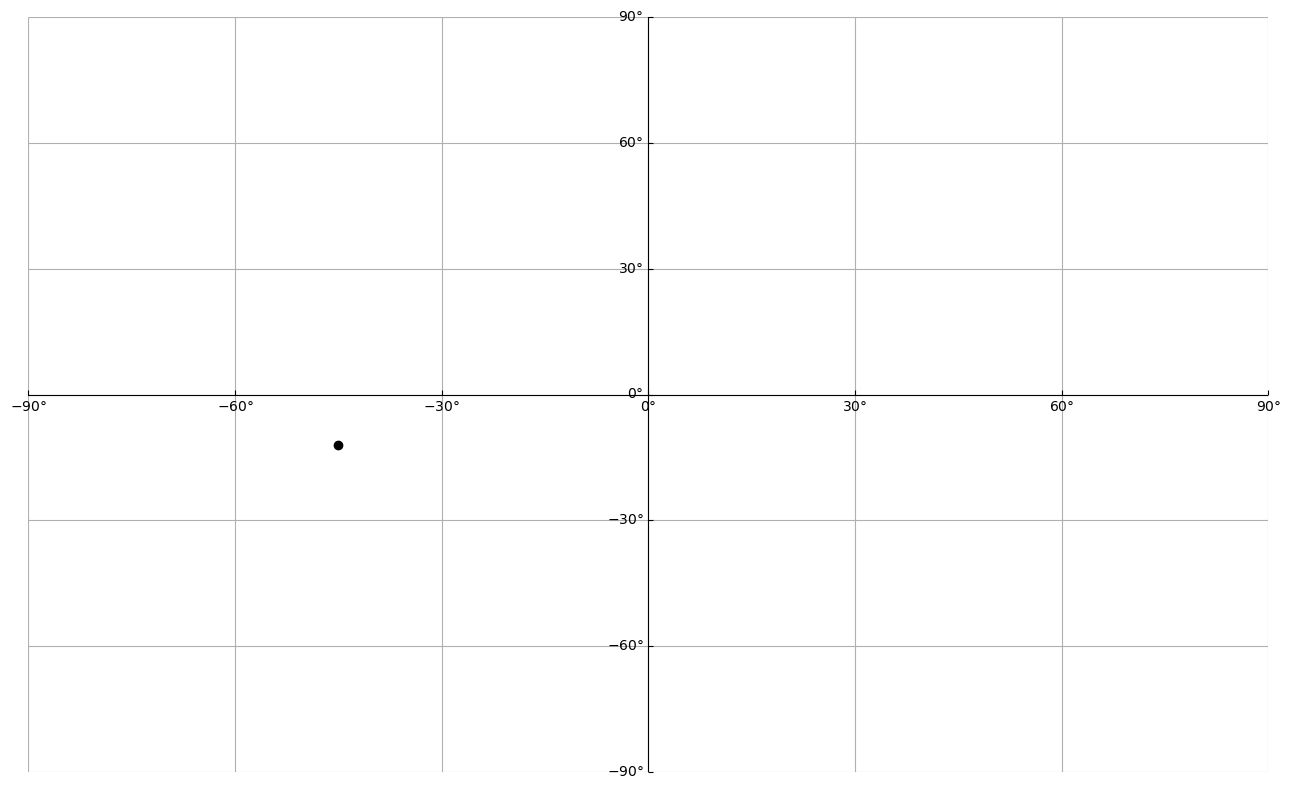

In [63]:
# Plots of received data in 1M and 2M PHY: Phase and Phase difference (COMPLEX PATTERN)

import math
import cmath
import json
import numpy as np
import matplotlib.pyplot as plt

###################################################################
### Constants

vel_air = 299702547 # m/s
freq = 2460000000 # Hz might depend on currently used channel
wave_len = vel_air/freq
d = 0.05

###################################################################
### Methods

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

def calc_mean(values):
    return sum(values)/len(values)

def calc_angle(deg_value, inverted, results):
    output = 0
    try:
        result = math.acos((np.deg2rad(deg_value)*wave_len)/(2*math.pi*d))
    except ValueError:
        pass
    else:
        if inverted:
            output = abs(to_plus_minus_pi(np.rad2deg(result)+180))
        else:
            output = abs(to_plus_minus_pi(np.rad2deg(result)))
        results.append(output)

###################################################################

data = []

# Load data with only valid IQ samples from JSON log  
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_16.51.51.json') as f:  # 45deg min height 2M PHY
with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.05.16.json') as f:  # 45deg min height 1M PHY
# with open('../logs/outdoor/2022.10.31/log_2022.10.31_15.03.12.json') as f:  # 30deg min height 1M PHY
    
        
    log = json.load(f)
    record_data = {
        "Header": log["Header"],
        "Records": [elem for elem in log["Records"] if len(elem["IQ"]) > 80]
    }
    data.append(record_data)

results_azimuth = []
results_elevation = []

# Iterate through each connection event 
for n in range(len(data[0]["Records"])-1):
    IQ = []

    # Iterate through each IQ sample to normalize it 
    for elem in data[0]["Records"][n]["IQ"]:
        I = elem[0]/128 if elem[0] < 0 else elem[0]/127
        Q = elem[1]/128 if elem[1] < 0 else elem[1]/127
        IQ.append(complex(I,Q))

    refPeriodDiff = []
    sampPeriodDiff = []
    refMeanDiff = 0

    # Iterate through each sample (82) in one connection event 
    for i in range(len(IQ)-1):
        # Phase calculation from IQ samples
        phaseCurrent = np.rad2deg(np.arctan2(IQ[i].imag, IQ[i].real))
        phaseNext = np.rad2deg(np.arctan2(IQ[i + 1].imag, IQ[i + 1].real))

        if (i < 7):
            refPeriodDiff.append(abs(to_plus_minus_pi(phaseNext - phaseCurrent)))
        elif (i == 7):
            refMeanDiff = calc_mean(refPeriodDiff)
        else:
            # 2*refMeanDiff as a in ref period sample is taken twice as fast as in sampling period, 
            # so it needs to be doubled
            sampPeriodDiff.append(to_plus_minus_pi((phaseNext - phaseCurrent) - 2*refMeanDiff))

    azimuth = []
    elevation = []
    inverted = False
    horizontal = True

    # Calculate direction angles
    for i in range(len(sampPeriodDiff)-1):
        # Skip corner differences samples
        if ((i + 1) % 4 == 0):
            if(not horizontal): 
                # Change to inverted after 2 sections of non inverted data due to opposite scanning direction
                inverted = not inverted
            # Change orientation after each section 
            horizontal = not horizontal
        else:
            if (horizontal):
                calc_angle(sampPeriodDiff[i], inverted, azimuth)
            else:
                calc_angle(sampPeriodDiff[i], inverted, elevation)

    results_azimuth.append(calc_mean(azimuth))
    results_elevation.append(calc_mean(elevation))

x = calc_mean(results_azimuth) - 90
y = calc_mean(results_elevation) - 90
print(f"Azimuth mean: {x}")
print(f"Elevation mean: {y}")

from mpl_toolkits.axisartist.axislines import AxesZero
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(16, 10), dpi=100)
ax = fig.add_subplot(axes_class=AxesZero)

for direction in ["xzero", "yzero"]:
    # adds arrows at the ends of each axis
    # ax.axis[direction].set_axisline_style("-|>")

    # adds X and Y-axis from the origin
    ax.axis[direction].set_visible(True)

for direction in ["left", "right", "bottom", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)

ax.set_xlim(-90,90)
ax.set_ylim(-90,90)
ax.grid(True)

ticks = np.arange(-90,91,30)
ax.set_xticks(ticks)
ax.set_xticklabels([f"${i}\degree$" for i in ticks])
ax.set_yticks(ticks)
ax.set_yticklabels([f"${i}\degree$" for i in ticks])
ax.plot(x, y,'ko')

plt.show()
